# Interpolation: An Introduction

Interpolation is the process of constructing a function that passes *exactly* through a given set of data points $(x_i, y_i)$. We use it when we know or measure values at discrete points but need values in between.

> Core idea: Use known data to rebuild a smooth function over the interval that contains the data.

## When (and When Not) to Use Interpolation
- Use when: Data are assumed to come from a smooth underlying function and you only need values *between* known points.
- Avoid for: Predicting far outside the data range (that is **extrapolation**) or when data are noisy (then **regression / smoothing** is usually better).

## Key Concepts
- Interpolation vs. Approximation: Interpolation matches all points exactly; approximation allows small errors to gain stability or simplicity.
- Degree / Order: A single global polynomial through $n$ points has degree at most $n-1$.
- Runge's Phenomenon: High-degree global polynomials can oscillate badly—especially near the interval ends.

## Fundamental Interpolation Methods Students Should Know
These form a practical toolkit; you should recognize when to use each:

1. Zero-Order (Nearest-Neighbor / Step) Interpolation  
   Simple, piecewise constant; fast but discontinuous.
2. Linear Interpolation  
   Connects points with straight lines; piecewise linear, continuous $C^0$, cheap, widely used.
3. Polynomial Interpolation (Lagrange Form)  
   Single global polynomial passing through all points; conceptually clear but can become unstable for many points.



## Visual Comparison of Methods
We'll illustrate the qualitative differences among three interpolation strategies on the same small dataset:

1. Zero-order (nearest / step) interpolation
2. Linear interpolation
3. Global Lagrange polynomial (degree $n-1$)

We'll sample a smooth underlying function (e.g. $f(x)=\sin(x)$ on an interval) at a modest number of points and compare:
- Fidelity at nodes (all match exactly except the step method is flat between)
- Smoothness between nodes
- Global vs. local behavior

After the plot:
- Notice blocky discontinuities for zero-order.
- Linear gives continuous but kinked ($C^0$, not $C^1$) segments.
- Lagrange is smooth ($C^\infty$) but may overshoot between sparsely spaced points.


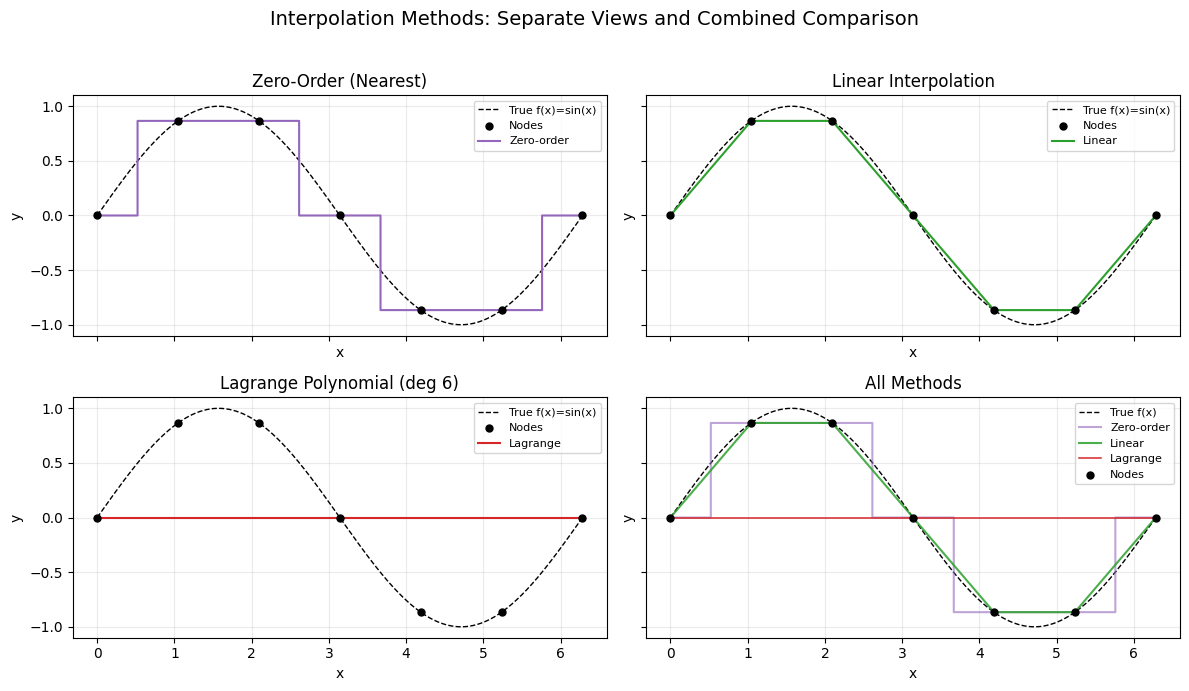

Observations:
 - Zero-order: Piecewise constant; discontinuities at midpoints between nodes.
 - Linear: Continuous, but slope breaks at each node (only C^0).
 - Lagrange: Smooth global polynomial; exact at nodes; slight global wiggles.
 - Combined: Trade-offs in smoothness vs. locality are visible.


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Underlying smooth function
f = np.sin

# Sample nodes (moderate number to show behavior without extreme oscillation)
x_nodes = np.linspace(0, 2*np.pi, 7)  # 7 points -> degree 6 Lagrange
y_nodes = f(x_nodes)

# Dense evaluation grid
x_dense = np.linspace(x_nodes.min(), x_nodes.max(), 800)

# 1. Zero-order (nearest) interpolation
def zero_order_interp(xq, x, y):
    xq = np.asarray(xq)
    idx = np.abs(xq[:, None] - x[None, :]).argmin(axis=1)
    return y[idx]

y_zero = zero_order_interp(x_dense, x_nodes, y_nodes)

# 2. Linear interpolation (vectorized built-in)
y_linear = np.interp(x_dense, x_nodes, y_nodes)

# 3. Lagrange polynomial (direct form; fine for small n)
def lagrange_eval(xq, x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    xq = np.asarray(xq)
    m = xq.size
    n = x.size
    result = np.zeros(m)
    for j in range(n):
        mask = np.arange(n) != j
        denom = np.prod(x[j] - x[mask])
        Lj = np.prod((xq[:, None] - x[mask][None, :]) / denom, axis=1)
        result += y[j] * Lj
    return result

y_lagrange = lagrange_eval(x_dense, x_nodes, y_nodes)

# Prepare subplots: one per method + combined overview
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True, sharey=True)
axes = axes.ravel()

# Plot style helper
def base(ax, title):
    ax.plot(x_dense, f(x_dense), 'k--', linewidth=1, label='True f(x)=sin(x)')
    ax.scatter(x_nodes, y_nodes, color='black', zorder=5, s=25, label='Nodes')
    ax.set_title(title)
    ax.grid(alpha=0.25)

# Zero-order
base(axes[0], 'Zero-Order (Nearest)')
axes[0].step(x_dense, y_zero, where='mid', color='tab:purple', label='Zero-order')

# Linear
base(axes[1], 'Linear Interpolation')
axes[1].plot(x_dense, y_linear, color='tab:green', label='Linear')

# Lagrange
base(axes[2], 'Lagrange Polynomial (deg 6)')
axes[2].plot(x_dense, y_lagrange, color='tab:red', label='Lagrange')

# Combined
axes[3].plot(x_dense, f(x_dense), 'k--', linewidth=1, label='True f(x)')
axes[3].step(x_dense, y_zero, where='mid', color='tab:purple', alpha=0.6, label='Zero-order')
axes[3].plot(x_dense, y_linear, color='tab:green', alpha=0.85, label='Linear')
axes[3].plot(x_dense, y_lagrange, color='tab:red', linewidth=1.1, label='Lagrange')
axes[3].scatter(x_nodes, y_nodes, color='black', s=25, zorder=5, label='Nodes')
axes[3].set_title('All Methods')
axes[3].grid(alpha=0.25)

for ax in axes:
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(fontsize=8)

plt.suptitle('Interpolation Methods: Separate Views and Combined Comparison', fontsize=14)
plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

print("Observations:\n" \
      " - Zero-order: Piecewise constant; discontinuities at midpoints between nodes.\n" \
      " - Linear: Continuous, but slope breaks at each node (only C^0).\n" \
      " - Lagrange: Smooth global polynomial; exact at nodes; slight global wiggles.\n" \
      " - Combined: Trade-offs in smoothness vs. locality are visible.")

## Basic Lagrange Interpolation (Quick Start)

This is the minimal, hands-on recipe for constructing the interpolating polynomial through given points.

### Problem
Given $n$ distinct points $(x_0,y_0), (x_1,y_1), \dots, (x_{n-1}, y_{n-1})$, find a polynomial $P(x)$ of degree at most $n-1$ such that $P(x_i)=y_i$ for all $i$.

### Idea
Build special building blocks $L_j(x)$ that are 1 at $x_j$ and 0 at every other node. Then combine them with the $y_j$ as weights.

### Basis Polynomials
$$L_j(x) = \prod_{\substack{i=0 \\ i \ne j}}^{n-1} \frac{x - x_i}{x_j - x_i}$$
(Each factor forces $L_j(x_i)=0$ for $i\ne j$ and the denominator normalizes so $L_j(x_j)=1$.)

### Interpolating Polynomial
$$P(x) = \sum_{j=0}^{n-1} y_j L_j(x)$$
Automatic correctness: $P(x_k)=y_k$ because all terms with $j\ne k$ vanish.

### Step-by-Step (Manual Example)
Suppose points $(0,1), (1,2), (2,0)$.
1. Compute $L_0(x) = \frac{(x-1)(x-2)}{(0-1)(0-2)} = \frac{(x-1)(x-2)}{2}$
2. $L_1(x) = \frac{(x-0)(x-2)}{(1-0)(1-2)} = - (x)(x-2)$
3. $L_2(x) = \frac{(x-0)(x-1)}{(2-0)(2-1)} = \frac{x(x-1)}{2}$
4. $P(x) = 1\cdot L_0(x) + 2\cdot L_1(x) + 0\cdot L_2(x)$; expand if desired.

### Quick Python Skeleton
```python
import numpy as np

def lagrange_basic(xq, x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    xq = np.atleast_1d(xq).astype(float)
    n = len(x)
    out = np.zeros_like(xq)
    for j in range(n):
        mask = np.arange(n) != j
        denom = np.prod(x[j] - x[mask])
        Lj = np.prod((xq[:, None] - x[mask]) / denom, axis=1)
        out += y[j] * Lj
    return out if out.size > 1 else out.item()
```

### When This Is Enough
- Small number of points (classroom demos, symbolic work).
- Need explicit polynomial form for algebraic manipulation.

### Limitations
- Numerical instability and slowness for larger $n$ (prefer barycentric form or piecewise splines).

### Key Takeaway
Lagrange interpolation is conceptually simple: construct “indicator” polynomials and mix them with the data values. Its elegance makes it ideal for understanding interpolation fundamentals, even if other methods are better computationally.


---

## The Big Rule: Number of Points vs. Polynomial Degree

A common point of confusion is the "order" or "degree" of the polynomial. The rule is simple and fundamental:

> For **n** data points, Lagrange interpolation gives you a unique polynomial of degree **at most n-1**.

* **2 points** define a unique **line** (degree 1).
* **3 points** define a unique **parabola** (degree 2).
* **4 points** define a unique **cubic** function (degree 3).

So, no, the degree of the polynomial is not the same as the number of data points; it's one less.

---

## A Word of Warning: The Problem with Too Many Points

So, what happens if we have thousands of points? Can we create a single polynomial of degree 999 to fit them all?

**Theoretically, yes. Practically, this is a terrible idea and the method becomes useless.**

### Runge's Phenomenon: Wild Oscillations
When you force a single, high-degree polynomial to go through many points, it tends to **oscillate wildly** between the points, especially near the ends. Even though it hits every point perfectly, the curve *between* the points is a horrible approximation of the true trend.


*This is a classic example of forcing a high-degree polynomial through a set of points. It's accurate at the points, but disastrously wrong in between.*

### The Real-World Solution: Splines
Instead of one massive, wiggly polynomial, the better approach for large datasets is **spline interpolation**. This method connects small groups of points with low-degree polynomials (like degree 3), creating a final curve that is both accurate and smooth. It's like using a flexible ruler to connect the dots smoothly.

